In [9]:
%matplotlib inline 
from ggplot import *
import pandas as pd
from os import listdir

def get_counts(fn):
    return pd.read_csv(fn, header=None, names=["value", "count"])

def load_output_dir(dn, fields=[]):
    retval = {}
    if not fields:
        files = listdir(dn)
        for l in files:
            fields.append(l[len("unique_"):-1 * len(".csv")])

    for d in fields:
        l = "{0}/unique_{1}.csv".format(dn, d)
        retval[d] = get_counts(l)
        
    return retval


def plot_bar(df, y, title, xlabel, ylabel, log=False):
    p = ggplot(aes(x="x", y=y), data=df) \
        + geom_bar(stat='identity') \
        + theme(axis_text_x = element_text(angle = 90, hjust = 0.5)) \
        + scale_x_discrete(limits=(0 - 0.5, df.shape[0] + 0.5), 
                           breaks=range(0, df.shape[0]), 
                           labels=df.index) \
        + ggtitle(title) \
        + xlab(xlabel) \
        + ylab(ylabel)
        
    if log:
        p = p + scale_y_log10()
        
    return p


def plot_hist(df, x, title, xlabel, ylabel):
    # Figure size: https://github.com/yhat/ggplot/issues/95
    p = ggplot(aes(x=x), data=df) \
    + geom_histogram() \
    + scale_x_continuous(limits=(0-0.01, max(df[x].max()+0.01, .11))) \
    + ggtitle(title) \
    + xlab(xlabel) \
    + ylab(ylabel) \
    + theme_matplotlib(rc={"figure.figsize": "11, 4", "figure.max_open_warning": False}, 
                       matplotlib_defaults=False)
    return p

In [39]:
# Subset of fields for developing graphs
testing_fields = ["dwc_country", "dwc_recordNumber", "dwc_locality"]

# small recordset
recordset = "00d9fcc1-c8e2-4ef6-be64-9994ca6a32c3"

# all of iDigBio ~4 min & 24 GB to load
#recordset = "idigbio"

In [40]:
counts = load_output_dir("../out_{0}".format(recordset), testing_fields)
counts_raw = load_output_dir("../out_raw_{0}".format(recordset), testing_fields)

['dwc_country', 'dwc_recordNumber', 'dwc_locality']
['dwc_country', 'dwc_recordNumber', 'dwc_locality']


In [35]:
# Build dataframe contianing the number of unique values for every field

c = {}
for k, df in counts.iteritems():
#    # reduce to just testing data
#    if testing_fields and not k in testing_fields:
#        continue
    c[k] = df.shape[0]

#print c
cardinalities = pd.DataFrame(c.values(), index=c.keys(), columns=["card"])

# Reduce the dataframe to just those fields that are not completely unique and those
# fields that are sparesely populated.
max_card = cardinalities.max()["card"] * 0.95
#min_card = cardinalities[cardinalities["card"] > 0].min()["card"] * 100
#min_card = 100000
min_card = 100
print max_card
print min_card
cardinalities = cardinalities[cardinalities["card"] < max_card]
cardinalities = cardinalities[cardinalities["card"] > min_card]


369736.2
100


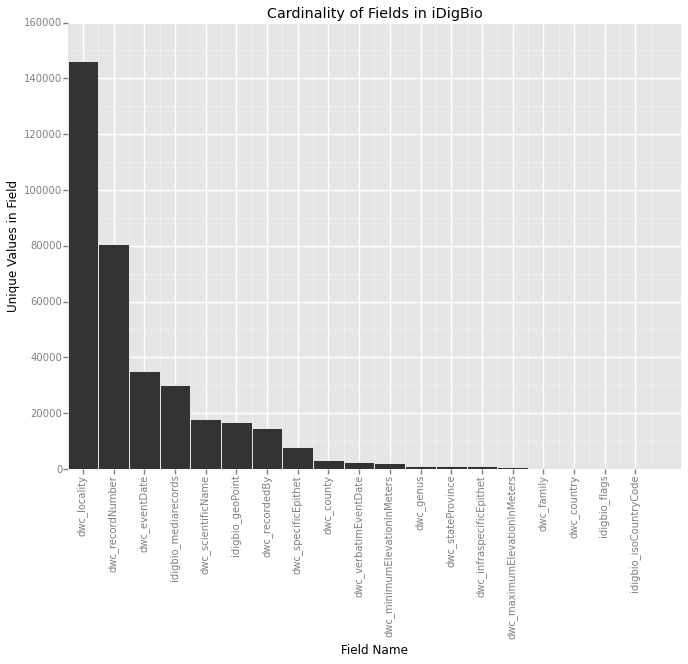

<ggplot: (8743330082789)>

In [19]:
# Sort for plotting and add an integer for the x-axis
cardinalities.sort(columns="card", inplace=True, ascending=False)
cardinalities["x"] = range(0, cardinalities.shape[0])


# small record set sizes: 187      389,196  146,346   80,476        3,180
#                         country  etag     locality  recordNumber  county

p = plot_bar(cardinalities, "card",
             "Cardinality of Fields in iDigBio",
             "Field Name",
             "Unique Values in Field")
p


In [25]:
if 1==0:
# Don't run this code
    # Now per-field frequency distributions of values
    # Really need some kind of normalization. 
    # 
    # Not that useful, these plots end up being a big spike on the left and a little spike on the
    # right. Keeping one running as an example
    # Sentance to read to interprete these: In this field, 
    # [y-axis] values occur in [x-axis] percent of the records.


    fields = ["dwc_kingdom"]
    #print counts[field]["count"].sum()
    #print counts[field].describe()
    #print counts[field].sort("count", ascending=True).head()
    #print counts[field].sort("count", ascending=False).head()

    figs = []
    for f in fields:
    #for f in counts.keys():

        counts[f]["norm"] = counts[f]["count"] / counts[f]["count"].sum()

        figs.append(plot_hist(counts[f], "norm", 
                      "Histogram of occurence of values in Field {0}".format(f), 
                      "Relative frequencey of how often the value occurs in this field", 
                      "Count of how many values occur this often")
                    )
    # Just put the array on the last line, don't try calling draw()
    figs

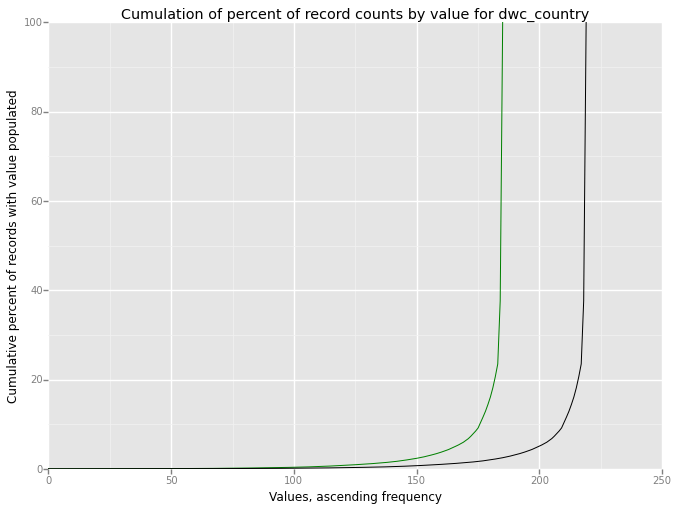

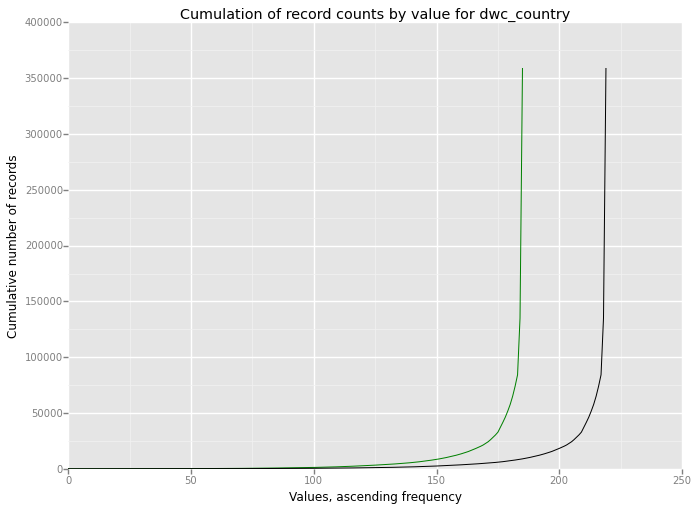

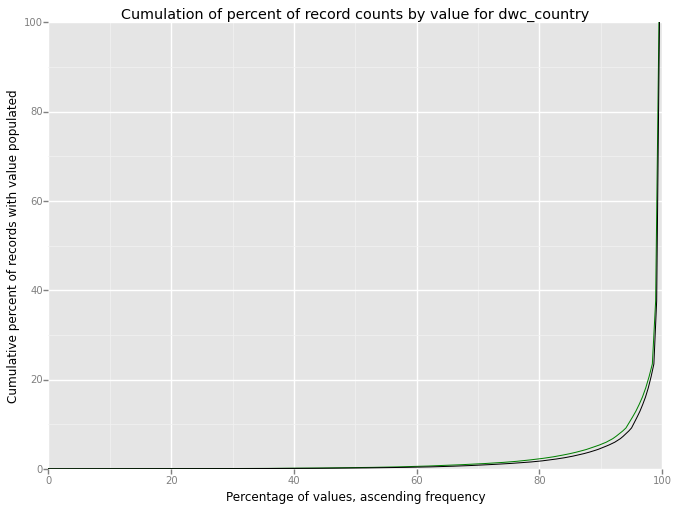

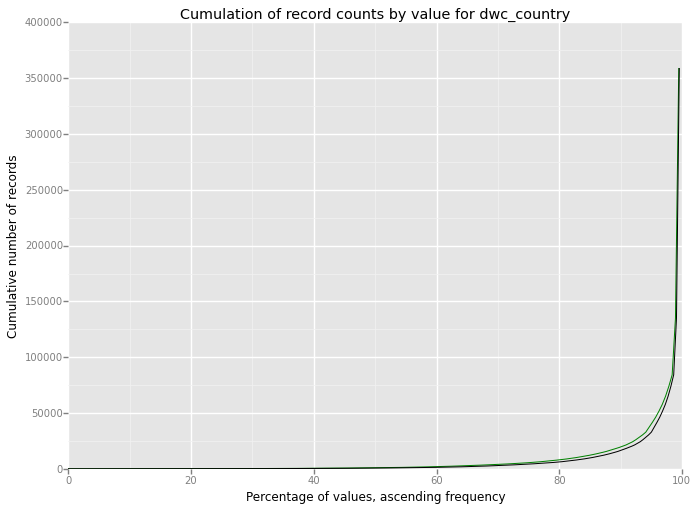

[<ggplot: (8743341735281)>,
 <ggplot: (8743341784157)>,
 <ggplot: (8743341735201)>,
 <ggplot: (8743341725085)>]

In [58]:
# As an alternative to the above, lets try a cumulative records graph. This shows the 
# cumulative number of records as each value is considered from most uncommon value to most 
# common.

def plot_line(df, df_raw, x, y, title, xlabel, ylabel, log=False):
    p = ggplot(aes(x=x, y=y), data=df) \
        + geom_line(size=1, color="green") \
        + geom_line(aes(x=x, y=y), data=df_raw, size=1) \
        + ggtitle(title) \
        + xlab(xlabel) \
        + ylab(ylabel)
#        + scale_x_discrete(limits=(0 - 0.5, df.shape[0] + 0.5), 
#                           breaks=range(0, df.shape[0]), 
#                           labels=df.index) \        
#  + theme(axis_text_x = element_text(angle = 90, hjust = 0.5)) \      
    if log:
        p = p + scale_y_log10()
        
    return p

def cumulate_df(df):
    # Remove blank/null value line, sort by increasing count
    df = df.sort("count")[ df["value"].notnull() ]
    
    # If the result is nothing left, return False
    if not df.shape[0] > 0:
        return False
    
    # Calculate cumulative count and percentage of records
    df["cum_count"] = df["count"].cumsum()
    df["cum_perc_pop"] = df["cum_count"] / df["count"].sum() * 100
    
    # add increasing integer x representing number of values for plotting
    df["x"] = range(0, df.shape[0])
    df["x_perc"] = df["x"] / df.shape[0] * 100
    
    return df

# Cumulate all the raw and corrected dataframes into dfs for graphing
dfs = {}
dfs_raw = {}
for f in testing_fields:
    dfs[f] = cumulate_df(counts[f])
    dfs_raw[f] = cumulate_df(counts_raw[f])

    
testing_fields = ["dwc_country"]
figs = []
for f in testing_fields:
    figs.append(plot_line(dfs[f], dfs_raw[f], "x", "cum_perc_pop",
                         "Cumulation of percent of record counts by value for {}".format(f),
                         "Values, ascending frequency",
                         "Cumulative percent of records with value populated"))
for f in testing_fields:
    figs.append(plot_line(dfs[f], dfs_raw[f], "x", "cum_count",
                         "Cumulation of record counts by value for {}".format(f),
                         "Values, ascending frequency",
                         "Cumulative number of records"))
for f in testing_fields:
    figs.append(plot_line(dfs[f], dfs_raw[f], "x_perc", "cum_perc_pop",
                         "Cumulation of percent of record counts by value for {}".format(f),
                         "Percentage of values, ascending frequency",
                         "Cumulative percent of records with value populated"))

for f in testing_fields:
    figs.append(plot_line(dfs[f], dfs_raw[f], "x_perc", "cum_count",
                         "Cumulation of record counts by value for {}".format(f),
                         "Percentage of values, ascending frequency",
                         "Cumulative number of records"))          
    
figs